<a href="https://www.kaggle.com/code/ravaghi/scientific-image-forgery-detection-u-net-2-2?scriptVersionId=291606458" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports and configs

In [1]:
import json

import numba
import numpy as np
from numba import types
import numpy.typing as npt
import pandas as pd
import scipy.optimize


class ParticipantVisibleError(Exception):
    pass


@numba.jit(nopython=True)
def _rle_encode_jit(x: npt.NDArray, fg_val: int = 1) -> list[int]:
    """Numba-jitted RLE encoder."""
    dots = np.where(x.T.flatten() == fg_val)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def rle_encode(mask):
    mask = mask.astype(bool)
    flat = mask.T.flatten()
    dots = np.where(flat)[0]
    
    if len(dots) == 0:
        return json.dumps([])
    
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend([b + 1, 0])
        run_lengths[-1] += 1
        prev = b
    
    run_lengths = [int(x) for x in run_lengths]
    return json.dumps(run_lengths)


@numba.njit
def _rle_decode_jit(mask_rle: npt.NDArray, height: int, width: int) -> npt.NDArray:
    """
    s: numpy array of run-length encoding pairs (start, length)
    shape: (height, width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    if len(mask_rle) % 2 != 0:
        # Numba requires raising a standard exception.
        raise ValueError('One or more rows has an odd number of values.')

    starts, lengths = mask_rle[0::2], mask_rle[1::2]
    starts -= 1
    ends = starts + lengths
    for i in range(len(starts) - 1):
        if ends[i] > starts[i + 1]:
            raise ValueError('Pixels must not be overlapping.')
    img = np.zeros(height * width, dtype=np.bool_)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img


def rle_decode(mask_rle: str, shape: tuple[int, int]) -> npt.NDArray:
    """
    mask_rle: run-length as string formatted (start length)
              empty predictions need to be encoded with '-'
    shape: (height, width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """

    mask_rle = json.loads(mask_rle)
    mask_rle = np.asarray(mask_rle, dtype=np.int32)
    starts = mask_rle[0::2]
    if sorted(starts) != list(starts):
        raise ParticipantVisibleError('Submitted values must be in ascending order.')
    try:
        return _rle_decode_jit(mask_rle, shape[0], shape[1]).reshape(shape, order='F')
    except ValueError as e:
        raise ParticipantVisibleError(str(e)) from e


def calculate_f1_score(pred_mask: npt.NDArray, gt_mask: npt.NDArray):
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()

    tp = np.sum((pred_flat == 1) & (gt_flat == 1))
    fp = np.sum((pred_flat == 1) & (gt_flat == 0))
    fn = np.sum((pred_flat == 0) & (gt_flat == 1))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    if (precision + recall) > 0:
        return 2 * (precision * recall) / (precision + recall)
    else:
        return 0


def calculate_f1_matrix(pred_masks: list[npt.NDArray], gt_masks: list[npt.NDArray]):
    """
    Parameters:
    pred_masks (np.ndarray):
            First dimension is the number of predicted instances.
            Each instance is a binary mask of shape (height, width).
    gt_masks (np.ndarray):
            First dimension is the number of ground truth instances.
            Each instance is a binary mask of shape (height, width).
    """

    num_instances_pred = len(pred_masks)
    num_instances_gt = len(gt_masks)
    f1_matrix = np.zeros((num_instances_pred, num_instances_gt))

    # Calculate F1 scores for each pair of predicted and ground truth masks
    for i in range(num_instances_pred):
        for j in range(num_instances_gt):
            pred_flat = pred_masks[i].flatten()
            gt_flat = gt_masks[j].flatten()
            f1_matrix[i, j] = calculate_f1_score(pred_mask=pred_flat, gt_mask=gt_flat)

    if f1_matrix.shape[0] < len(gt_masks):
        # Add a row of zeros to the matrix if the number of predicted instances is less than ground truth instances
        f1_matrix = np.vstack((f1_matrix, np.zeros((len(gt_masks) - len(f1_matrix), num_instances_gt))))

    return f1_matrix


def oF1_score(pred_masks: list[npt.NDArray], gt_masks: list[npt.NDArray]):
    """
    Calculate the optimal F1 score for a set of predicted masks against
    ground truth masks which considers the optimal F1 score matching.
    This function uses the Hungarian algorithm to find the optimal assignment
    of predicted masks to ground truth masks based on the F1 score matrix.
    If the number of predicted masks is less than the number of ground truth masks,
    it will add a row of zeros to the F1 score matrix to ensure that the dimensions match.

    Parameters:
    pred_masks (list of np.ndarray): List of predicted binary masks.
    gt_masks (np.ndarray): Array of ground truth binary masks.
    Returns:
    float: Optimal F1 score.
    """
    f1_matrix = calculate_f1_matrix(pred_masks, gt_masks)

    # Find the best matching between predicted and ground truth masks
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(-f1_matrix)
    # The linear_sum_assignment discards excess predictions so we need a separate penalty.
    excess_predictions_penalty = len(gt_masks) / max(len(pred_masks), len(gt_masks))
    return np.mean(f1_matrix[row_ind, col_ind]) * excess_predictions_penalty


def evaluate_single_image(label_rles: str, prediction_rles: str, shape_str: str) -> float:
    shape = json.loads(shape_str)
    label_rles = [rle_decode(x, shape=shape) for x in label_rles.split(';')]
    prediction_rles = [rle_decode(x, shape=shape) for x in prediction_rles.split(';')]
    return oF1_score(prediction_rles, label_rles)


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    Args:
        solution (pd.DataFrame): The ground truth DataFrame.
        submission (pd.DataFrame): The submission DataFrame.
        row_id_column_name (str): The name of the column containing row IDs.
    Returns:
        float

    Examples
    --------
    >>> solution = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['authentic', 'authentic', 'authentic'], 'shape': ['authentic', 'authentic', 'authentic']})
    >>> submission = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['authentic', 'authentic', 'authentic']})
    >>> score(solution.copy(), submission.copy(), row_id_column_name='row_id')
    1.0

    >>> solution = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['authentic', 'authentic', 'authentic'], 'shape': ['authentic', 'authentic', 'authentic']})
    >>> submission = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102]', '[101, 102]', '[101, 102]']})
    >>> score(solution.copy(), submission.copy(), row_id_column_name='row_id')
    0.0

    >>> solution = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102]', '[101, 102]', '[101, 102]'], 'shape': ['[720, 960]', '[720, 960]', '[720, 960]']})
    >>> submission = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102]', '[101, 102]', '[101, 102]']})
    >>> score(solution.copy(), submission.copy(), row_id_column_name='row_id')
    1.0

    >>> solution = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 103]', '[101, 102]', '[101, 102]'], 'shape': ['[720, 960]', '[720, 960]', '[720, 960]']})
    >>> submission = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102]', '[101, 102]', '[101, 102]']})
    >>> score(solution.copy(), submission.copy(), row_id_column_name='row_id')
    0.9983739837398374

    >>> solution = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102];[300, 100]', '[101, 102]', '[101, 102]'], 'shape': ['[720, 960]', '[720, 960]', '[720, 960]']})
    >>> submission = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102]', '[101, 102]', '[101, 102]']})
    >>> score(solution.copy(), submission.copy(), row_id_column_name='row_id')
    0.8333333333333334
    """
    df = solution
    df = df.rename(columns={'annotation': 'label'})

    df['prediction'] = submission['annotation']
    # Check for correct 'authentic' label
    authentic_indices = (df['label'] == 'authentic') | (df['prediction'] == 'authentic')
    df['image_score'] = ((df['label'] == df['prediction']) & authentic_indices).astype(float)

    df.loc[~authentic_indices, 'image_score'] = df.loc[~authentic_indices].apply(
        lambda row: evaluate_single_image(row['label'], row['prediction'], row['shape']), axis=1
    )
    return float(np.mean(df['image_score']))

In [2]:
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import albumentations as A
import pandas as pd
import numpy as np
import warnings
import random
import shutil
import joblib
import torch
import glob
import cv2
import os

warnings.filterwarnings('ignore')

/usr/local/lib/python3.11/dist-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context

In [3]:
class CFG:
    dataset_path = "/kaggle/input/recodai-luc-scientific-image-forgery-detection"
    model_path = "/kaggle/input/scientific-image-forgery-detection-u-net-1-2/Unet/efficientnet-b5/imagenet"
    
    model_name = 'Unet'
    encoder_name = 'efficientnet-b5'
    encoder_weights = 'imagenet'
    
    n_folds = 5
    seed = 42
    
    image_size = 512
    use_tta = False

In [4]:
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(CFG.seed)
torch.manual_seed(CFG.seed)
torch.cuda.manual_seed(CFG.seed)
torch.cuda.manual_seed_all(CFG.seed)  
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(CFG.seed)
random.seed(CFG.seed)

# Data loading and preprocessing

In [5]:
def get_data(dataset_path, is_train=True):
    if is_train:
        train_image_paths = glob.glob(f"{dataset_path}/train_images/**/*.png")
        supplemental_image_paths = glob.glob(f"{dataset_path}/supplemental_images/*.png")
        
        dataset = []
        for image_path in train_image_paths:
            image_id = image_path.split("/")[-1].split(".")[0]
            label = "authentic" if "authentic" in image_path else "forged"
            
            unique_case_id = f"train_{image_id}_{label}"
                
            dataset.append({
                "case_id": image_id,
                "label": label,
                "source": "train",
                "unique_case_id": unique_case_id,
                "image_path": image_path,
                "mask_path": None if label == "authentic" else f"{dataset_path}/train_masks/{image_id}.npy"
            })
            
        for image_path in supplemental_image_paths:
            image_id = image_path.split("/")[-1].split(".")[0]
            label = "forged"
            
            unique_case_id = f"supplemental_{image_id}_{label}"
                
            dataset.append({
                "case_id": image_id,
                "label": label,
                "source": "supplemental",
                "unique_case_id": unique_case_id,
                "image_path": image_path,
                "mask_path": f"{dataset_path}/supplemental_masks/{image_id}.npy"
            })
            
        return pd.DataFrame(dataset)
    
    else:
        image_paths = glob.glob(f"{dataset_path}/test_images/*.png")
        
        dataset = []
        for image_path in image_paths:
            image_id = image_path.split("/")[-1].split(".")[0]
                
            dataset.append({
                "case_id": image_id,
                "label": None,
                "source": "test",
                "unique_case_id": f"test_{image_id}_unknown",
                "image_path": image_path,
                "mask_path": None
            })
            
        return pd.DataFrame(dataset)

## Custom dataset for training and inference

In [6]:
class CustomDataset(Dataset):
    def __init__(self, dataset, image_size, transform, mode='train'):
        self.dataset = dataset
        self.image_size = image_size
        self.transform = transform
        self.mode = mode
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        
        if self.mode == 'train':
            image = cv2.imread(row['image_path'])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            if row['label'] == 'forged':
                mask = np.load(row["mask_path"])
                if len(mask.shape) == 3:
                    mask = np.max(mask, axis=0)
                else:
                    mask = np.squeeze(mask)
                mask = (mask > 0).astype(np.float32)
            else:
                mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)

            image = cv2.resize(image, (self.image_size, self.image_size))
            mask = cv2.resize(mask, (self.image_size, self.image_size))
            
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            
            return image, mask.unsqueeze(0)
        
        else:
            image = cv2.imread(row['image_path'])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            original_size = image.shape[:2]
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            augmented = self.transform(image=image)
            image = augmented['image']

            return row['case_id'], row['unique_case_id'], image, original_size

## Augmentations

In [7]:
def get_augmentations(is_train):
    train_augmentations = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=20, p=1),
            A.RandomGamma(gamma_limit=(80, 120), p=1),
        ], p=0.5),
        A.OneOf([
            A.GaussNoise(var_limit=(10.0, 50.0), p=1),
            A.GaussianBlur(blur_limit=(3, 5), p=1)
        ], p=0.3),
        A.Normalize(),
        ToTensorV2()
    ])

    val_augmentations = A.Compose([
        A.Normalize(),
        ToTensorV2()
    ])
    
    if is_train:
        return train_augmentations
    else:
        return val_augmentations

# Inference

In [8]:
class Trainer:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

    def postprocess(self, prob_map, low_thresh, high_thresh, min_size, kernel_size):
        strong_mask = (prob_map > high_thresh).astype(np.uint8)
        weak_mask = (prob_map > low_thresh).astype(np.uint8)
        
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(weak_mask, connectivity=8)
        
        final_mask = np.zeros_like(weak_mask)
        for i in range(1, num_labels):
            component_mask = (labels == i).astype(np.uint8)
            if np.bitwise_and(component_mask, strong_mask).any():
                final_mask[labels == i] = 1
                
        contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(final_mask, contours, -1, 1, thickness=cv2.FILLED)
        
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_OPEN, kernel)
        final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, kernel)
        
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(final_mask, connectivity=8)
        output_mask = np.zeros_like(final_mask)
        
        valid_indices = []
        for i in range(1, num_labels):
            if stats[i, cv2.CC_STAT_AREA] >= min_size:
                valid_indices.append(i)
        
        if len(valid_indices) != 2:
            valid_indices = []
            
        for i in valid_indices:
            output_mask[labels == i] = 1
                
        return output_mask

    def predict(self, model_paths, dataset, image_size=512, mode='test', use_tta=False):
        def predict_with_tta(model, images):
            model.eval()
            predictions = []
            
            with torch.no_grad():
                pred = torch.sigmoid(model(images))
                predictions.append(pred)
                
                pred = torch.sigmoid(model(torch.flip(images, dims=[3])))
                predictions.append(torch.flip(pred, dims=[3]))
                
                pred = torch.sigmoid(model(torch.flip(images, dims=[2])))
                predictions.append(torch.flip(pred, dims=[2]))
            
            return torch.stack(predictions).mean(0)
        
        models = []
        for model_path in tqdm(model_paths, desc='Loading models'):
            model = smp.from_pretrained(model_path, encoder_weights=None).eval().to(self.device)
            models.append(model)
        
        test_dataset = CustomDataset(dataset, image_size=image_size, transform=get_augmentations(is_train=False), mode=mode)
        test_loader = DataLoader(
            test_dataset, 
            batch_size=16,
            shuffle=False, 
            num_workers=2,
            pin_memory=True
        )
        
        predictions = []
        for batch_ids, _, batch_images, batch_original_sizes in tqdm(test_loader, desc='Running inference'):
            batch_images = batch_images.to(self.device)
            batch_size = batch_images.size(0)
            
            batch_fold_preds = []
            for model in models:
                if use_tta:
                    batch_pred = predict_with_tta(model, batch_images)
                else:
                    with torch.no_grad():
                        batch_pred = torch.sigmoid(model(batch_images))
                
                batch_fold_preds.append(batch_pred.cpu().numpy())
            
            batch_final_preds = np.mean(batch_fold_preds, axis=0).squeeze()

            for i in range(batch_size):
                image_id = batch_ids[i]
                original_h = batch_original_sizes[0][i].item()
                original_w = batch_original_sizes[1][i].item()
                
                final_pred = batch_final_preds[i]
                mask = cv2.resize(final_pred, (original_w, original_h), interpolation=cv2.INTER_LINEAR)

                mask = self.postprocess(
                    mask, 
                    min_size=14, 
                    kernel_size=7, 
                    low_thresh=0.1385934029488286, 
                    high_thresh=0.8221253120841039
                )
                
                if mask.sum() < 14:
                    annotation = 'authentic'
                else:
                    annotation = rle_encode(mask)
                
                predictions.append({
                    'case_id': image_id,
                    'annotation': annotation
                })
        
        return pd.DataFrame(predictions)

In [9]:
trainer = Trainer(CFG.dataset_path)

submission = trainer.predict(
    model_paths=[f"{CFG.model_path}/fold_{fold}" for fold in range(CFG.n_folds)],
    dataset=get_data(dataset_path=CFG.dataset_path, is_train=False),
    image_size=CFG.image_size,
    mode='test',
    use_tta=CFG.use_tta
)

submission.to_csv("submission.csv", index=False)

Loading models:   0%|          | 0/5 [00:00<?, ?it/s]

Loading weights from local directory
Loading weights from local directory
Loading weights from local directory
Loading weights from local directory
Loading weights from local directory


Running inference:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
submission

,case_id,annotation
0,45,authentic


# Visualizing the results

In [11]:
histories = joblib.load(f"{CFG.model_path}/histories.pkl")
fold_scores = joblib.load(f"{CFG.model_path}/fold_scores.pkl")

for fold_idx, score in enumerate(fold_scores):
    print(f"Fold {fold_idx+1} competition score: {score:.4f}")
    
print(f"\nMean competition score: {np.mean(fold_scores):.4f}")

Fold 1 competition score: 0.6076
Fold 2 competition score: 0.5937
Fold 3 competition score: 0.5292
Fold 4 competition score: 0.6154
Fold 5 competition score: 0.5965

Mean competition score: 0.5885


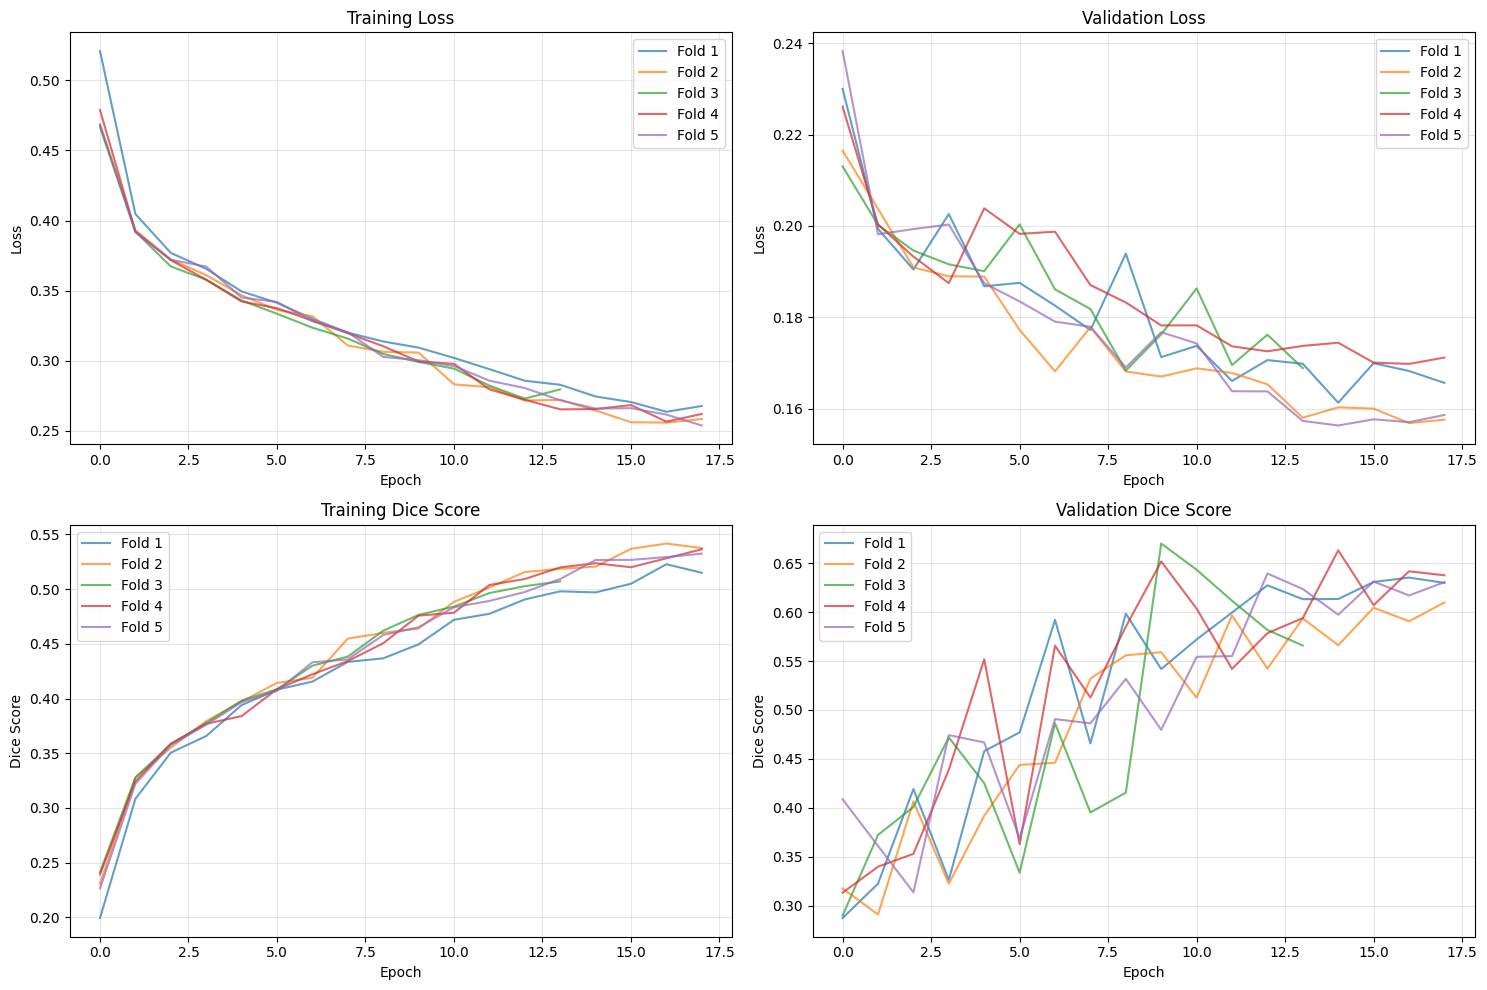

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for fold_idx in range(5):
    history = histories[fold_idx]
    
    axes[0].plot(history['epoch'], history['train_loss'], label=f'Fold {fold_idx+1}', alpha=0.7)
    axes[1].plot(history['epoch'], history['valid_loss'], label=f'Fold {fold_idx+1}', alpha=0.7)
    axes[2].plot(history['epoch'], history['train_dice'], label=f'Fold {fold_idx+1}', alpha=0.7)
    axes[3].plot(history['epoch'], history['valid_dice'], label=f'Fold {fold_idx+1}', alpha=0.7)

axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].set_title('Training Dice Score')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Dice Score')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

axes[3].set_title('Validation Dice Score')
axes[3].set_xlabel('Epoch')
axes[3].set_ylabel('Dice Score')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()